In [1]:
import os
import re
import sys
import subprocess
import xml.etree.cElementTree as ET
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def fetch_statistics_data(accession, timeout=20):
    cmd = ['sra-stat', '-xse', '2', accession]
    try:
        p = subprocess.run(
            cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            timeout=timeout,
        )
        return p.stdout
    except subprocess.TimeoutExpired:
        raise subprocess.TimeoutExpired(f"Command {cmd} execute timed out")

def check_file_header(filepath):
    with open(filepath, 'rb') as f:
        header = f.read(8).decode()
        return header == 'NCBI.sra'

def check_accession_format(accession):
    return True if re.fullmatch('[DES]RR[0-9]+$', accession) else False

In [3]:
class SequenceReadArchive:
    def __init__(self, accession):
        if (os.access(accession, os.F_OK) and check_file_header(accession)) or check_accession_format(accession):
            self._statistics_data = fetch_statistics_data(accession)
            self._xml_tree = ET.fromstring(self._statistics_data)
            
    def base_count(self, qscore=0):
        count = 0
        for qual in self._xml_tree.findall('*/Quality'):
            if int(qual.attrib['value']) >= qscore:
                count += int(qual.attrib['count'])
        return count
        
    @property
    def layout(self):
        return self._xml_tree.find('Statistics').attrib['nreads']
    
    @property
    def length(self):
        return tuple(map(lambda x: int(x.attrib['average']), self._xml_tree.findall('*//Read')))

In [4]:
sra = SequenceReadArchive('ERR019408')

In [8]:
sra.base_count(30)/sra.base_count()

0.2574499990336461

In [3]:
df = pd.read_csv('/media/GenomicResearch/Issue/NCBI/Run_Info/Salmonella_enterica_SraRunInfo.csv', parse_dates=['ReleaseDate', 'LoadDate'], low_memory=False)

df = df[df['download_path'].notna()]

df['ReleaseDate'] = pd.to_datetime(df['ReleaseDate'].dt.date)

df['ReleaseYear'] = df['ReleaseDate'].dt.year

In [12]:
df.shape[0]*5/1000000

2.148725

In [3]:
df = df[df['ReleaseYear']!=2022]

<AxesSubplot:>

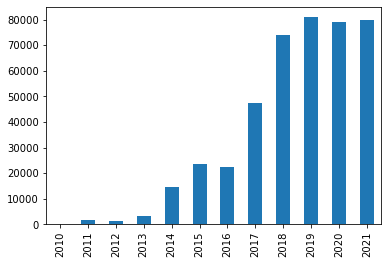

In [4]:
df['ReleaseYear'].value_counts().sort_index().plot.bar()

In [ ]:
df['ReleaseYear'] = df['ReleaseDate'].dt.year
# df = df[df['ReleaseYear']>2010]
df = df[df['download_path'].notna()]

In [ ]:
df['ReleaseYear'].value_counts()

In [ ]:
subsamples = pd.concat(group.sample(100) for year, group in df.groupby('ReleaseYear'))

In [ ]:
def fn(run_acc):
    try:
        sra = SequenceReadArchive(run_acc)
        return 'Pass' if sra.count(30)/sra.total_bases*100 >= 80 and sra.layout == '2' else 'Fail'
    except Exception:
        return 'Fail'

with ThreadPoolExecutor(64) as executor:
    results = []
    for run_acc, date in zip(subsamples['Run'], subsamples['ReleaseDate']):
        future = executor.submit(fn, run_acc)
        results.append((run_acc, date, future))

In [ ]:
quality_check = [(run_acc, date, future.result()) for run_acc, date, future in results]

In [ ]:
df2 = pd.DataFrame(quality_check, columns=['RunAccession', 'ReleaseDate', 'QualityFilter'])
df2

In [ ]:
df2['ReleaseYear'] = df2['ReleaseDate'].dt.year

In [ ]:
df3 = df2.groupby('ReleaseYear')['QualityFilter'].value_counts(normalize=True).mul(100).astype(int)
df3.name = 'Ratio'
df3 = df3.reset_index()

In [ ]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(5, 3), dpi=150)
    g = sns.barplot(x='ReleaseYear', y='Ratio', hue='QualityFilter', data=df3, ax=ax)
    g.set_xticklabels(g.get_xmajorticklabels(), rotation=45)
    g.legend(bbox_to_anchor=(1.05, .7), loc=2, title='QualityFilter')
    g.set_ylim(-5, 105)

In [ ]:
fig.savefig('/media/Access/3_個人儲存區/陳柏翰/NCBI_SRA_Quality_Filter.png', dpi=300, facecolor='w', bbox_inches='tight')